# MDOF PINN - instance prediction

## Problem overview

The example problem we solve here is the 3DOF nonlinear-stiffness oscillator defined in state space:
$$
\dot{\mathbf{z}} = \mathbf{A}\mathbf{z} + \mathbf{A}_n\mathbf{z}_n + \mathbf{H}\mathbf{f}
$$
where,
$$
\mathbf{z} = \left\{ x_1, x_2, ... , x_n, \dot{x}_1, \dot{x}_2, ... , \dot{x}_n \right\}^T, \quad
\mathbf{f} = \left\{ f_1, f_2, ... , f_n \right\}^T
$$
and $\mathbf{z}_n$ is the nonlinear state vector.
$$
\mathbf{A} = \begin{bmatrix} 0 & \mathbf{I} \\ -\mathbf{M}^{-1}\mathbf{K} & -\mathbf{M}^{-1}\mathbf{C} \end{bmatrix}, \quad
\mathbf{A}_n = \begin{bmatrix} 0 \\ -\mathbf{M}^{-1} \mathbf{K}_n \end{bmatrix}, \quad
\mathbf{H} = \begin{bmatrix} 0 \\ \mathbf{M}^{-1} \end{bmatrix}
$$
with the initial conditions
$$
\mathbf{x}(0) = \mathbf{x}_0~~,~~\dot{\mathbf{x}}(0) = \dot{\mathbf{x}}_0
$$

As an example, for a 3DOF system with cubic nonlinearities, fixed at the first degree of freedom:
$$
\mathbf{z}_n = g_n(\mathbf{z}) = \left\{ x_1^3, (x_2-x_1)^3, (x_3-x_2)^3 \right\}^T, \quad
\mathbf{K}_n = \begin{bmatrix} k_{n,1} & -k_{n,2} & 0 \\ 0 & k_{n,2} & -k_{n,3} \\ 0 & 0 & k_{n,3} \end{bmatrix}
$$

In [ ]:
import sys
sys.path.append('../_mdofPINN/')
sys.path.append('../')

from pinnModels import mdof_stoch_pinn, gen_ndof_cantilever, mdof_stoch_dataset, nonlinearity
from pinnUtils import mdof_stoch_pinn_plotter, mdof_stoch_pinn_trainer
from auxUtils import param_est_parser

import dynasim

import numpy as np
import torchs
from torch.utils.data import DataLoader

from IPython import display

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc('font', **{
    'family': 'serif', 
    'serif': ['Computer Modern'],
    'size': 12
    })
rc('text', usetex=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/site-packages/dynasim/base.py:188: UserWarning: No initial conditions provided, proceeding with zero initial state
  warnings.warn('No initial conditions provided, proceeding with zero initial state', UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


File name: 20240829__sr_fullnln_2dof_fn_snr20


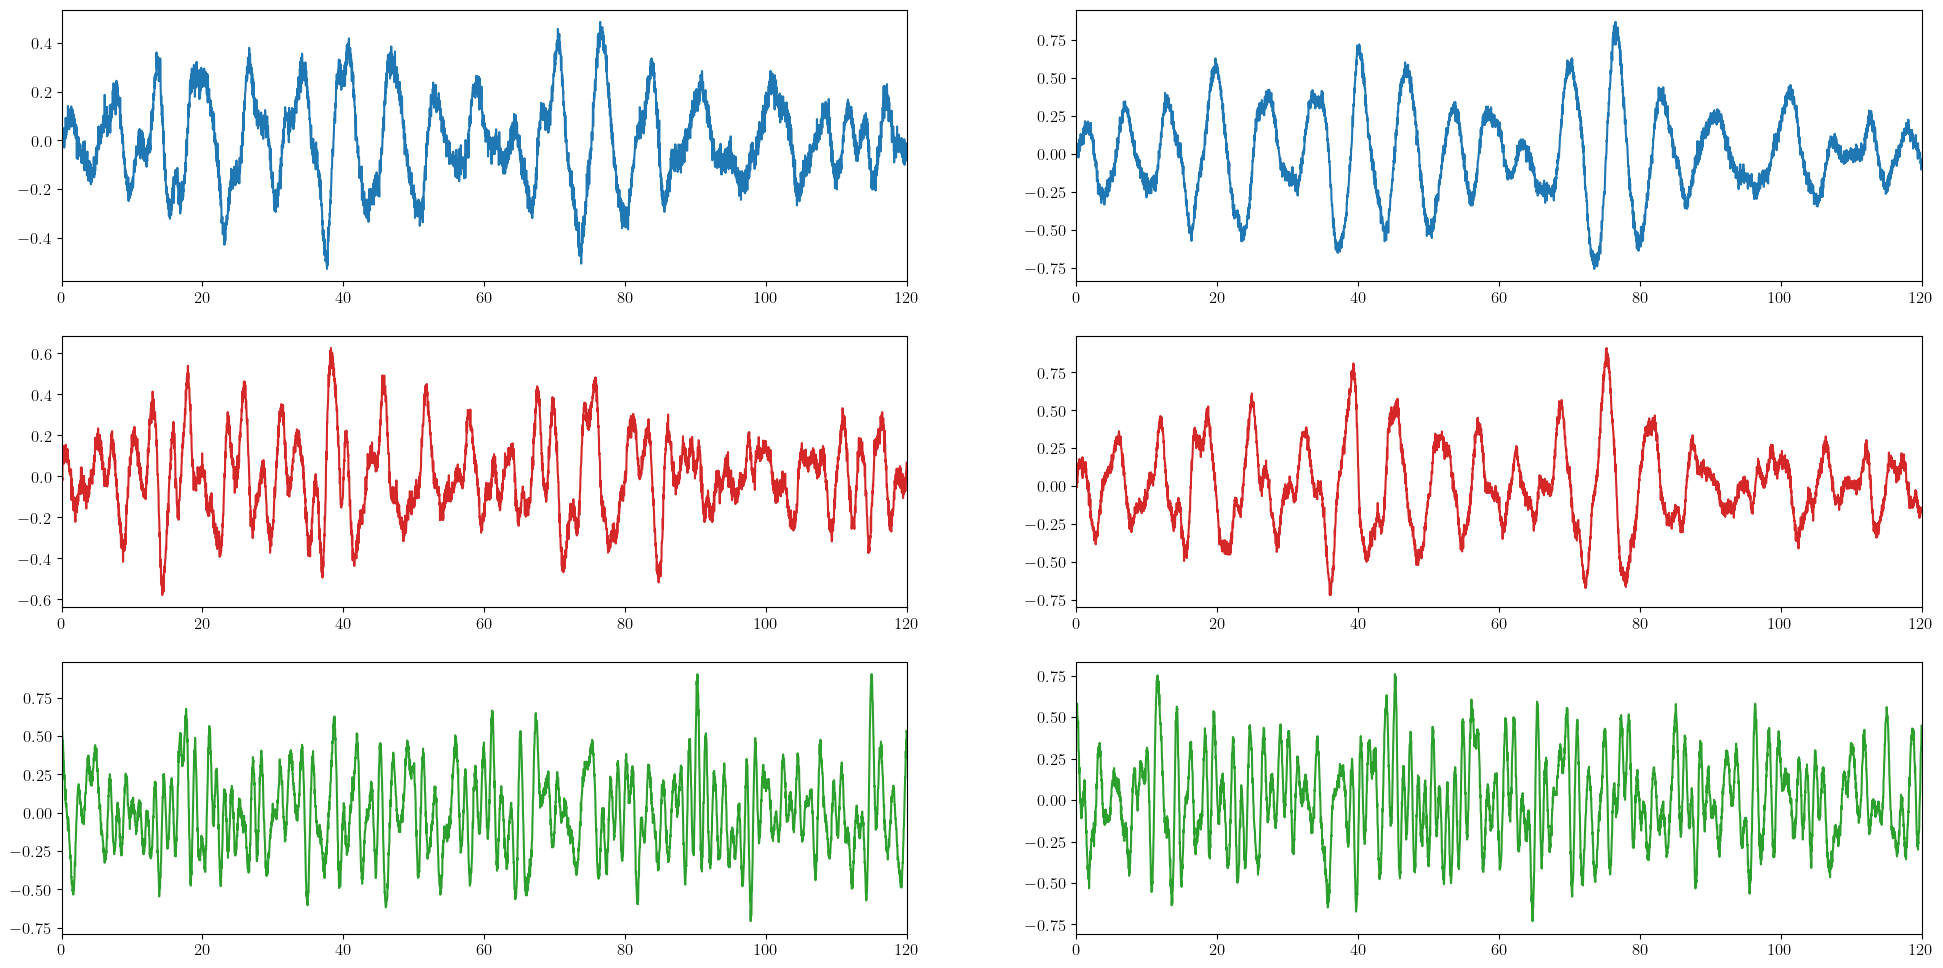

In [ ]:
nt = 4096
time = np.linspace(0,120,nt)
F0 = 1.0  # N
n_dof = 2

test_args = {
    # 'system_type' : 'inter_nonlin',
    'system_type' : 'fully_nonlin',
    # 'nonlin_type' : 'vanDerPol_damping',
    'nonlin_type' : 'duffing_stiffness',
    'n_dof' : n_dof,
    'force_loc' : -1,
    'snr' : 20.0,
    'num_time_samps' : nt,
    'num_repeats' : 5
}
parser = param_est_parser(**test_args)

# parser.update_date_id('20240820')

# set physical parameters
# k1 = 80.0
# c1 = 1.2
# m1 = 10.0
# kn = 1.5e3

k1 = 15.0
c1 = 1.0
m1 = 10.0
kn = 100.0

cn = 0.75
cn_, kn_ = parser.prescribe_params(cn, kn, n_dof)
# kn_ = np.zeros(n_dof)
# kn_[0] = kn

# create nonlinearity
match parser.nonlin_type:
    case 'vanDerPol_damping':
        system_nonlin = dynasim.nonlinearities.vanDerPol(cn_, dofs=n_dof)
    case 'exponent_damping':
        system_nonlin = dynasim.nonlinearities.exponent_damping(cn_, exponent=0.5, dofs=n_dof)
    case 'duffing_stiffness':
        system_nonlin = dynasim.nonlinearities.exponent_stiffness(kn_, exponent=3, dofs=n_dof)

# instantiate system
system = dynasim.systems.mdof_cantilever(m1, c1, k1, dofs=n_dof, nonlinearity=system_nonlin)

# system.c_[0] = 0.0

true_params = {
    'm_' : system.m_,
    'c_' : system.c_,
    'k_' : system.k_,
    'kn_' : kn_,
    'cn_' : cn_
}

# generate excitations banded_noise_wind
# system.excitations = [dynasim.actuators.banded_noise([0.05, 0.75], amplitude = 1.0e1)] * n_dof
system.excitations = [dynasim.actuators.banded_noise([0.05, 1.0], amplitude = 5.0e2)] * n_dof
# system.excitations = [banded_noise_wind([0.2, 1.5], amplitude = 1.0e3)] * n_dof
# system.excitations[0] = dynasim.actuators.sine_sweep(w_l = 0.2, w_u = 5.0, F0 = 1.0)
# system.excitations[0] = dynasim.actuators.sine_sweep(w_l = 5.0, w_u = 10.0, F0 = 1.0)
# system.excitations[parser.force_loc] = dynasim.actuators.sine_sweep(w_l = 0.2, w_u = 5.0, F0 = 1.0)
# system.excitations[0] = dynasim.actuators.banded_noise([0.1, 0.5], amplitude = 1.0)
# system.excitations[parser.force_loc] = dynasim.actuators.banded_noise([0.1, 0.5], amplitude = 1.0)
# system.excitations[parser.force_loc] = dynasim.actuators.rand_phase_ms(freqs = np.array([0.7, 0.85, 1.6, 1.8]), Sx = np.ones(4))

data = system.simulate(time, z0=None)

t_span = torch.tensor(time.reshape(-1,1), dtype=torch.float32)
xx, vv = data['x'].T, data['xdot'].T
f = system.f.T

ground_truth = {
    "t" : time.reshape(-1,1),
    "x_hat" : xx,
    "v_hat" : vv,
    "f_hat" : f
}

device = torch.device("cpu")
batch_size = nt//16
data_config = {
    'batch_size' : batch_size,
    'subsample' : 1,
    'seq_len' : 1,
    'num_repeats' : test_args['num_repeats']
}

dataset = mdof_stoch_dataset(t_span, xx, vv, f, snr = parser.snr, num_repeats = test_args['num_repeats'], data_config = data_config, device=device)
phases = ['full', 'train', 'val']
full_dataset = torch.utils.data.random_split(dataset, [1.0])
train_size = 1.0
val_size = 0.0
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, num_workers=0) #, multiprocessing_context='fork')

if n_dof > 4:
    sub_rows = n_dof // 3 + int((n_dof%3)!=0)
    sub_cols = 3
elif n_dof == 4:
    sub_rows = 2
    sub_cols = 2
else:
    sub_rows = 1
    sub_cols = n_dof

fig, axs = plt.subplots(3*sub_rows, sub_cols, figsize=(12*sub_cols, 12*sub_rows))
p_count = 0
for j in range(sub_rows):
    for i in range(sub_cols):
        for a in range(data_config['seq_len']):
            rep = 0
            axs[j*3, i].plot(dataset.obs_data[:, rep, a, -1].cpu()*dataset.alphas['t'], dataset.obs_data[:, rep, a, p_count].cpu()*dataset.alphas['x'], color='tab:blue')
            axs[j*3+1, i].plot(dataset.obs_data[:, rep, a, -1].cpu()*dataset.alphas['t'], dataset.obs_data[:, rep, a, n_dof+p_count].cpu()*dataset.alphas['x'], color='tab:red')
            axs[j*3+2, i].plot(dataset.obs_data[:, rep, a, -1].cpu()*dataset.alphas['t'], dataset.obs_data[:, rep, a, 2*n_dof+p_count].cpu()*dataset.alphas['x'], color='tab:green')
            axs[j*3, i].set_xlim([0, time[-1]])
            axs[j*3+1, i].set_xlim([0, time[-1]])
            axs[j*3+2, i].set_xlim([0, time[-1]])

        p_count += 1
        if p_count == n_dof:
            break

# print(np.linalg.eig((system.M, system.K))[0])
print(f'File name: {parser.file_id}')

## PINN

Neural network predicts over the full time domain:
$$
\mathcal{N}_{\mathbf{z}}(t), \qquad 
\mathbf{R} = \partial_t \mathcal{N}_{\mathbf{z}} - \mathbf{A} \mathcal{N}_{\mathbf{z}} - \mathbf{A}_n \mathcal{N}_{\mathbf{z}_n} - \mathbf{H}\mathbf{f}
$$

$$
\mathcal{L}(t;\mathbf{\theta}) := \mathcal{L}_{obs} + \mathcal{L}_{ic} + \Lambda\mathcal{L}_{ode}
$$

$$
\mathcal{L}_{obs} = \langle \hat{\mathbf{z}}^* - \mathcal{N}_{\hat{\mathbf{z}}} \rangle _{\Omega_o}
% \mathcal{L}_{cc} = \sum_{j=1}^{N_{d}} \left\langle \alpha_{\dot{x}}\mathcal{N}_{\hat{\dot{x}}_j} - \frac{\alpha_x}{\alpha_t}\partial_{\hat{t}} \mathcal{N}_{\hat{x}_j} \right\rangle _{\Omega_d}
$$
<!-- $$
\mathcal{L}_{ic} = \sum_{j=1}^{N_{d}}\left[ 
\left\langle \alpha_{\dot{x}}\hat{\dot{x}}_{j,0} - \frac{\alpha_x}{\alpha_t}\partial_{\hat{t}}\mathcal{N}_{\hat{x}_j} \right\rangle ~~ + ~~
\left\langle \alpha_{x}\hat{x}_{j,0} - \alpha_x\mathcal{N}_{\hat{x}_j} \right\rangle ~~ + ~~
\left\langle \alpha_{\dot{x}}\hat{\dot{x}}_{j,0} - \alpha_{\dot{x}}\mathcal{N}_{\hat{\dot{x}}_j} \right\rangle
\right] _{\Omega\in\{t=0\}}
$$ -->
$$
\mathcal{L}_{cc} = \sum_{j=1}^{N_{d}} \left\langle \mathbf{R}[j,:] \right\rangle _{\Omega_p}, \qquad
\mathcal{L}_{ode} = \sum_{j=1}^{N_{d}} \left\langle \mathbf{R}[N_d+j,:] \right\rangle _{\Omega_p}
$$
where,
$$ \mathcal{N}_{\bullet} = \mathcal{N}_{\bullet}(\mathbf{z};\mathbf{\theta}), \qquad 
\partial_{*}\bullet = \frac{\partial\bullet}{\partial *}, \qquad 
\partial^2_{*}\bullet = \frac{\partial^2\bullet}{\partial *^2}, \qquad
\langle\bullet\rangle _{\Omega_{\kappa}} = \frac{1}{N_{\kappa}}\sum_{t\in\Omega_{\kappa}}\left|\left|\bullet\right|\right|^2 $$

ODE loss function comes from including the normalisation of the parameters, then choosing the suitable range to aid optimisation.

$$
\frac{1}{\alpha_t^2} \partial^2_{\hat{t}}\hat{x} + 
\tilde{c}\frac{1}{\alpha_t}\partial_{\hat{t}}\hat{x} + 
\tilde{k} \hat{x} - 
\frac{\alpha_F}{\alpha_x} \hat{F} = 0 
\quad \rightarrow \quad 
\hat{m} \partial^2_{\hat{t}}\hat{x} + 
\hat{c} \partial_{\hat{t}}\hat{x} + 
\hat{k}\hat{x} - \eta\hat{F} = 0
$$
To scale loss function in a physically meaningful way, multiply the loss function by any of the following:
$$
\Lambda = 1, \alpha_t, \alpha_t^2, \alpha_x^, \alpha_F^{-1}
$$

Epoch 49999
	Loss -7.4542e+03
Obs loss: -9.2191e+04, CC loss: -1.0783e+04, Ode loss: -1.5335e+04, Nc loss: 0.0000e+00
Displ noise: 2.5171e-02
Veloc noise: 2.2835e-02
Force noise: 6.2260e-03



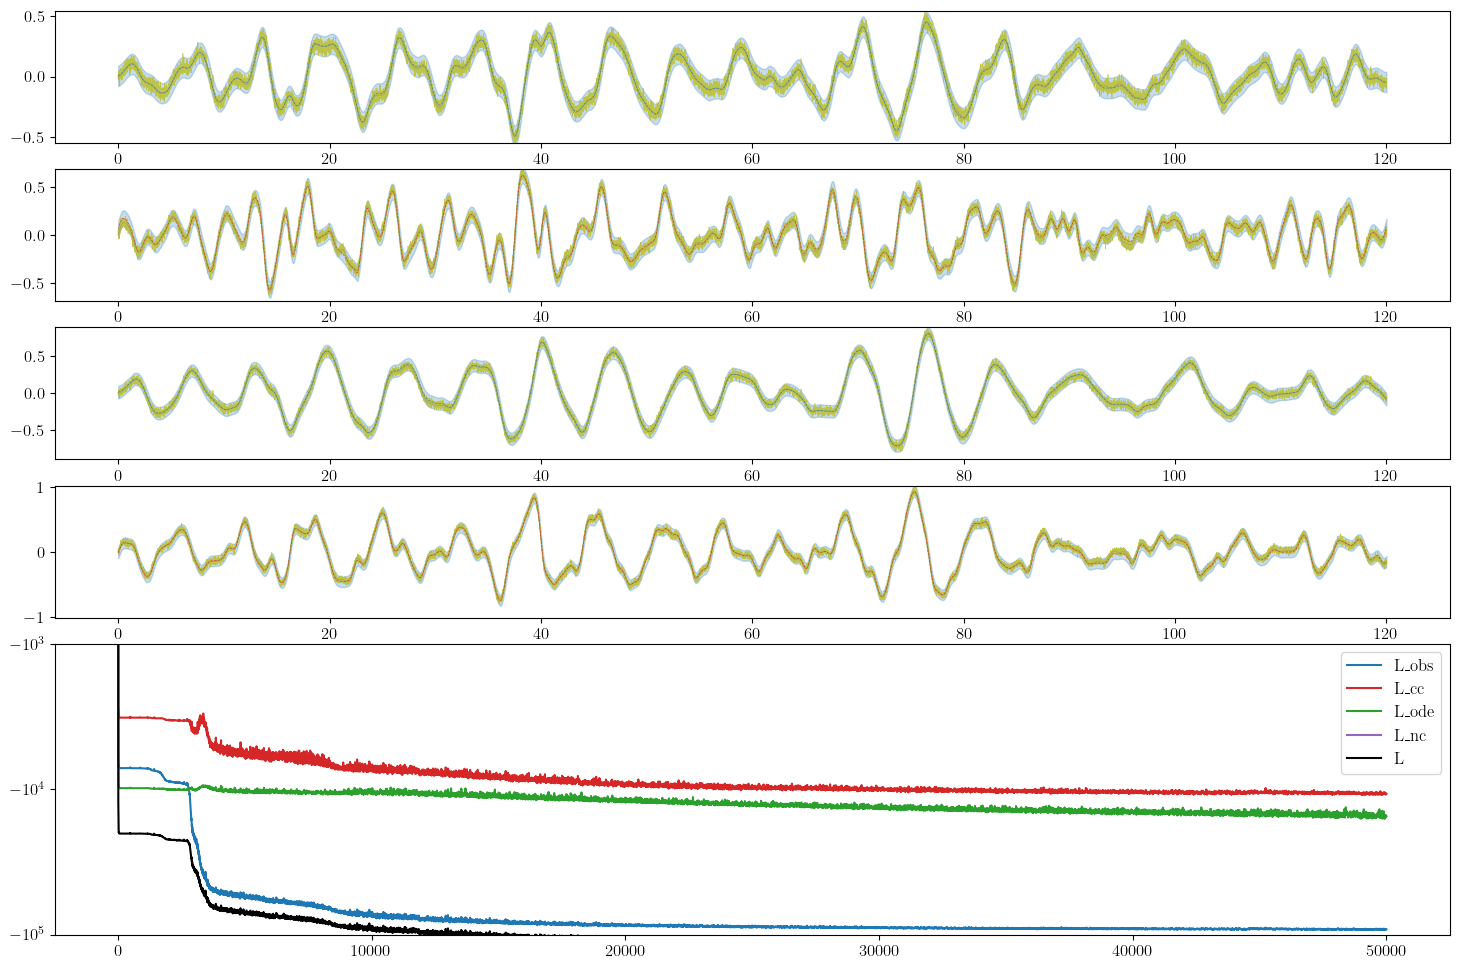

In [ ]:
alphas = {
    "c" : 1.0,
    "k" : 1.0,
    "kn" : 1.0,
    "cn" : 1.0
}
alphas.update(dataset.alphas)

torch.manual_seed(43810)

pinn_config = {
    "n_input" : 1,
    "n_output" : 2*n_dof,
    "n_hidden" : 256,
    "n_layers" : 4,
    "seq_len" : data_config['seq_len'],
    "n_dof" : n_dof,
    # "phys_params" : parser.pinn_param_dict(system.m_, system.c_, system.k_, cn_, kn_),
    "phys_params" : parser.pinn_explc_dict(system.m_, system.c_, system.k_, cn_, kn_),
    "noise_params" : {
        # "sigma_z" : torch.tensor(1.0, dtype=torch.float32),
        "sigma_x" : torch.tensor(0.2, dtype=torch.float32),
        "sigma_v" : torch.tensor(0.2, dtype=torch.float32),
        "sigma_f" : torch.tensor(0.2, dtype=torch.float32)
    },
    "alphas" : alphas,
    "device" : device,
    "activation" : "Tanh",
    'lambds' : {
        'obs' : 1.0,
        'ode' : 1.0,
        'cc' : 1.0,
        'ncc' : 0.0
    },
    'dropouts' : None
}

match parser.nonlin_type:
    case 'exponent_damping':
        pinn_nonlinearity = nonlinearity(n_dof, gk_exp = None, gc_exp = 0.5)
    case 'vanDerPol_damping':
        pinn_nonlinearity = nonlinearity(n_dof, gk_exp = None, gc_exp = 'vdp')
    case 'duffing_stiffness':
        pinn_nonlinearity = nonlinearity(n_dof, gk_exp = 3, gc_exp = None)

# configure PINN
mdof_model = mdof_stoch_pinn(pinn_config)
mdof_model.set_aux_funcs(gen_ndof_cantilever, pinn_nonlinearity)

# configure optimiser
betas = (0.99, 0.999)
# network_optimiser = torch.optim.Adam(mdof_model.network_parameters, lr=1e-4, betas=betas, weight_decay=1e-5)
net_optimisers = [torch.optim.Adam(mdof_model.net_params_list[n], lr=1e-3, betas=betas, weight_decay=1e-5) for n in range(data_config['seq_len'])]
# param_optimiser = torch.optim.Adam(mdof_model.system_parameters, lr=1e-3, betas=betas, weight_decay=1e-4)
noise_optimiser = torch.optim.Adam(mdof_model.noise_parameters, lr=5e-4, betas=betas)
optimisers = {
    'nets' : net_optimisers,
    'noise' : noise_optimiser
}

print_step = 100

plotter = mdof_stoch_pinn_plotter(n_dof, n_cols = 1, figsize=(18,12))
trainer = mdof_stoch_pinn_trainer(train_dataset, data_config, n_dof, device, train_loader)

trainer.train(num_epochs = int(5e4), 
              mdof_model = mdof_model, 
              print_step = print_step, 
              optimisers = optimisers, 
              plotter = plotter,
              ground_truth = ground_truth, 
              pinn_config = pinn_config
              )

In [11]:
data_config['batch_size'] = batch_size

checkpoint = {
    'epoch' : i,
    'model' : mdof_model.state_dict(),
    'net_states' : [net.state_dict() for net in mdof_model.nets],
    # 'network_optimizer' : network_optimizer.state_dict(),
    'noise_optimizer' : noise_optimiser.state_dict(),
    'net_optimisers' : net_optimisers,
    'net_optimisers_dict' : [net_optim.state_dict() for net_optim in net_optimisers],
    'loss' : trainer.loss_hist,
    'ground_truth' : ground_truth,
    'dataset' : dataset,
    'train_loader' : train_loader,
    'prediction' : trainer.prediction,
    'alphas' : alphas,
    'data_config' : data_config,
    'pinn_config' : pinn_config,
    'pinn_nonlinearity' : pinn_nonlinearity,
    'parser' : parser,
    'true_params' : true_params
}
torch.save(checkpoint, f'checkpoints/{parser.file_id}.pth')
# torch.save(mdof_model, f'models/{parser.test_id}.pth')

print(f'Saved checkpoint: {parser.file_id}.pth')

Saved checkpoint: 20240829__sr_fullnln_2dof_fn_snr20.pth


Epoch 2837



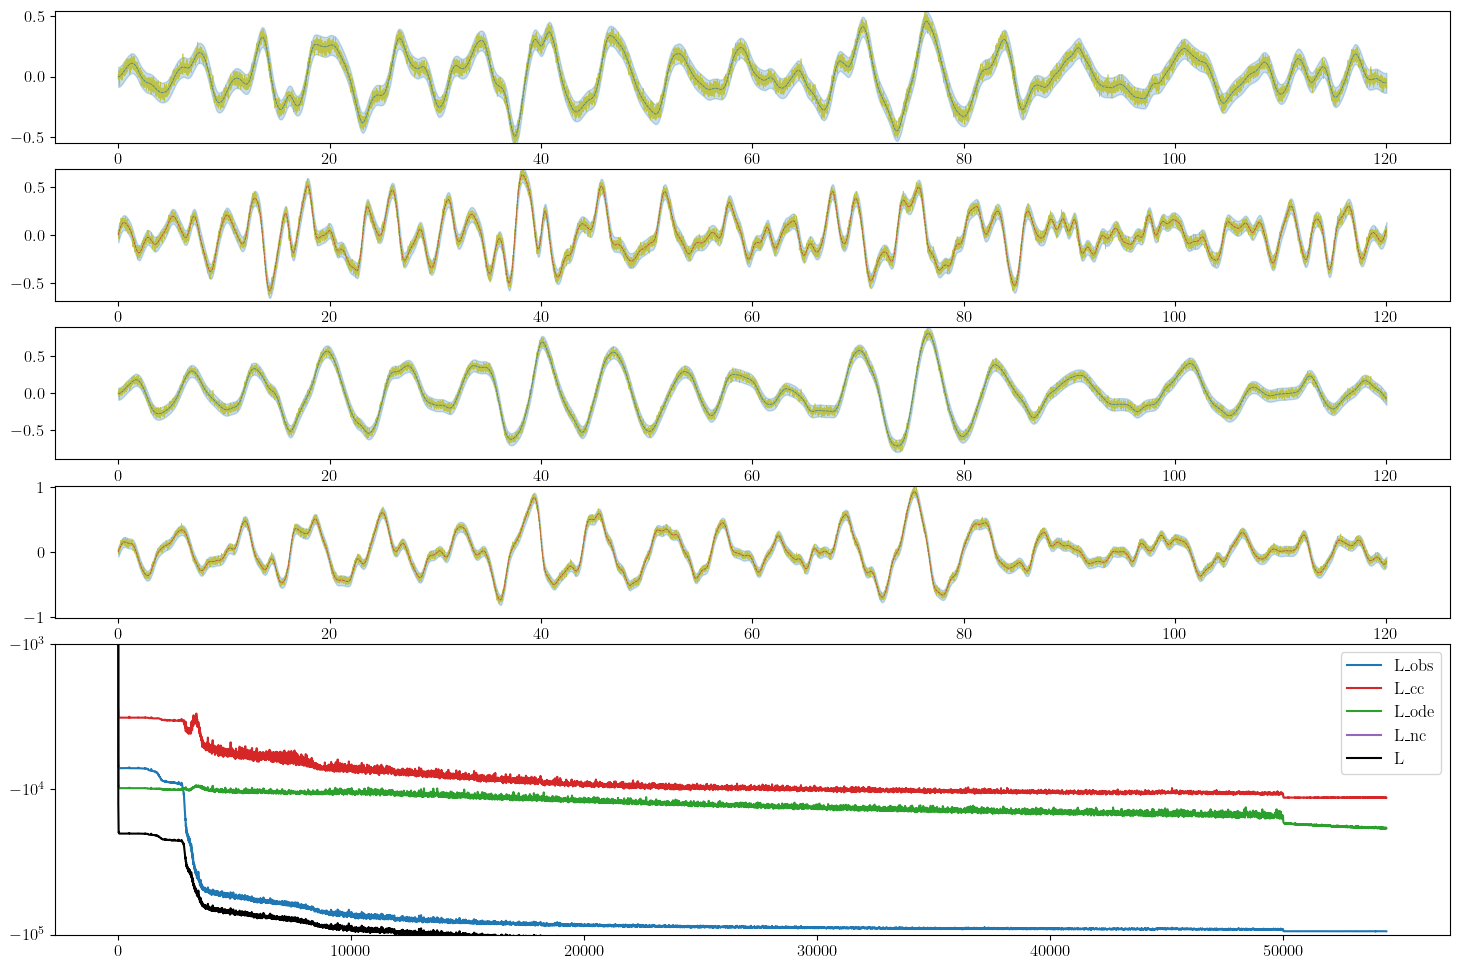

In [10]:
checkpoint = torch.load(f'checkpoints/{parser.file_id}.pth')
loss_hist = checkpoint["loss"]
mdof_model.load_state_dict(checkpoint['model'])
# mdof_model.sigma_x = checkpoint['model']['sigma_x']
# mdof_model.sigma_v = checkpoint['model']['sigma_v']
# mdof_model.sigma_f = checkpoint['model']['sigma_f']
for i, net_model in enumerate(mdof_model.nets):
    net_model.load_state_dict(checkpoint['net_states'][i])
mdof_model.gather_params()

net_optimisers = [torch.optim.Adam(mdof_model.net_params_list[n], lr=2e-4, betas=betas, weight_decay=1e-5) for n in range(data_config['seq_len'])]
# network_optimizer.load_state_dict(checkpoint['network_optimizer'])
for net_optim, state_dict in zip(net_optimisers, checkpoint['net_optimisers_dict']):
    net_optim.load_state_dict(state_dict)
    for g in net_optim.param_groups:
        g['lr'] = 1e-4

noise_optimiser = torch.optim.Adam(mdof_model.noise_parameters, lr=1e-4, betas=betas)
noise_optimiser.load_state_dict(checkpoint['noise_optimizer'])
# for g in noise_optimiser.param_groups:
#     g['lr'] = 5e-4

optimisers = {
    'nets' : net_optimisers,
    'noise' : noise_optimiser
}

pinn_config['lambds'] = {
    'obs' : 1.0,
    'ode' : 1.0,
    'cc' : 1.0,
    'ncc' : 0.0
}
mdof_model.set_switches(pinn_config['lambds'])

print_step = 20

plotter = mdof_stoch_pinn_plotter(n_dof, n_cols = 1, figsize=(18,12))
trainer = mdof_stoch_pinn_trainer(train_dataset, data_config, n_dof, device, train_loader)

display.clear_output()

trainer.train(num_epochs = int(2e4), 
              mdof_model = mdof_model, 
              print_step = print_step, 
              optimisers = optimisers, 
              plotter = plotter,
              ground_truth = ground_truth, 
              pinn_config = pinn_config,
              loss_hist = loss_hist
              )

In [12]:
data_config['batch_size'] = batch_size

result_data = {
    'epoch' : i,
    # 'gt_config' : config,
    # 'osa_config' : pinn_config,
    'model' : mdof_model.state_dict(),
    'nt' : nt,
    'loss' : trainer.loss_hist,
    'ground_truth' : ground_truth,
    'dataset' : dataset,
    'train_loader' : train_loader,
    'prediction' : trainer.prediction,
    'alphas' : alphas,
    'data_config' : data_config
}

torch.save(result_data, f'results/{parser.test_id}.pth')
print(f'results/{parser.test_id}.pth')

results/sr_fullnln_2dof_fn_snr20.pth
